## **ПРАКТИЧЕСКОЕ ЗАДАНИЕ**

**Задача тематическое моделирование**

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

рабочие ссылки с твитами
https://disk.yandex.ru/i/v5HM-ENiGXZVpQ
https://disk.yandex.ru/i/koR5eMCToCZS2Q

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [ ]:
# импортируем библиотеки

import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm
import json
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from multiprocessing import Pool
!pip install -U gensim
from gensim.models import *
from gensim import corpora
! pip install pymorphy2
import pymorphy2
from pymystem3 import Mystem
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [ ]:
# вспомогательные функции

morph = pymorphy2.MorphAnalyzer()
words_regex = re.compile('\w+')
stopwords_list = stopwords.words('russian') + ['всё', 'это', 'который', 'наш', 'вообще', 'это']

# функция создания токенов
def find_words(text, regex=words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

## функция лемматизации и удаления стоп-слов
# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

# функция лемматизации и удаления стоп-слов
def lemmatize(words, lemmer=morph, stopwords=stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

# функция предобработки текста
def preprocess(text):
    return (lemmatize(find_words(text)))

### **ПАРСИНГ ДАННЫХ С РОСПОТРЕБНАДЗОРА**

In [102]:
# # найдем id каждого вопроса на страницах

# page = 1
# main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

# def ids_from_page(soup):
#     return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
# urls = []
# for page in tqdm(range(1, 500), desc='Pages'):
#     time.sleep(0.5)
#     res = requests.get(main_url.format(page=page))  
#     soup = BeautifulSoup(res.text)
#     urls.extend(ids_from_page(soup))

In [103]:
# # имея id запросов, достанем тексты на страницах, ответ нам не нужен

# domain = 'https://zpp.rospotrebnadzor.ru'

# def get_text_page_question(soup):
#     return soup.findAll('p', {'class':'appeal-details-message'})[0].text
# def get_text_page_answer(soup):
#     return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

# question = []
# # answers = []

# for url in tqdm(urls, desc='Pages'):
#     time.sleep(0.5)
#     res = requests.get(urljoin(domain, url))  
#     soup = BeautifulSoup(res.text)
    
#     question.append(get_text_page_question(soup))
# #     try:
# #         answers.append(get_text_page_answer(soup))
# #     except:
# #         answers.append('No answer')

In [104]:
# # посмотрим, что скачалось

# N = 2
# print('Q:', question[N])
# # print()
# # print('A:', answers[N])

In [105]:
# # сохраним данные в формат json

# question_list = {'question': question}

# with open('rospotrebnadzor.json', 'w') as json_file:
#     json.dump(question_list, json_file)

### **ПРЕДОБРАБОТКА**

In [106]:
# загрузим данные

with open('/content/drive/MyDrive/Colab Notebooks/NLP/rospotrebnadzor.json', 'r') as f:
  data = json.load(f)

questions = data['question']
print(len(questions))

2495


In [107]:
print(questions[0])  # пример с исходными данными
print(preprocess(questions[0]))  # пример с обработанными данными

Супермаркет "Удача" по ул. Степана Разина, 6 (г. Иркутск) реализует картофель с выраженным зеленным оттенком, прошу проверить
['супермаркет', 'удача', 'степан', 'разин', 'иркутск', 'реализовать', 'картофель', 'выраженный', 'зеленной', 'оттенок', 'просить', 'проверить']


In [108]:
# обработаем весь массив вопросов
preprocessed_text = list(tqdm(map(preprocess, questions), total=len(questions)))

  0%|          | 0/2495 [00:00<?, ?it/s]

### **ТЕМАТИЧЕСКАЯ МОДЕЛЬ LDA**

In [109]:
# создадим словарь слов
dictionary = corpora.Dictionary(preprocessed_text)

# игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.filter_extremes(no_below=10, no_above=0.9, keep_n=None) 
dictionary.save('rpn.dict')

In [110]:
# создадим вектора текстов
corpus = [dictionary.doc2bow(text) for text in preprocessed_text]
corpora.MmCorpus.serialize('rpn.model', corpus) 

In [111]:
%time 

# обучим модель для 20 тематик
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [112]:
# выведем получившиеся темы
lda.show_topics(num_topics=20, num_words=10, formatted=True)

[(0,
  '0.048*"ремонт" + 0.046*"подсказать" + 0.045*"центр" + 0.034*"мочь" + 0.026*"сеть" + 0.026*"часть" + 0.025*"написать" + 0.023*"гарантийный" + 0.021*"день" + 0.021*"мвидео"'),
 (1,
  '0.047*"личный" + 0.046*"сайт" + 0.046*"почта" + 0.044*"тест" + 0.042*"руб" + 0.038*"оформить" + 0.035*"кабинет" + 0.031*"оплата" + 0.031*"электронный" + 0.029*"условие"'),
 (2,
  '0.232*"товар" + 0.210*"магазин" + 0.072*"продавец" + 0.048*"интернет" + 0.026*"приобрести" + 0.024*"вернуть" + 0.024*"качество" + 0.024*"купить" + 0.023*"данный" + 0.022*"изделие"'),
 (3,
  '0.350*"услуга" + 0.065*"мастер" + 0.059*"работа" + 0.045*"оказать" + 0.042*"оплачивать" + 0.039*"спустя" + 0.038*"вызвать" + 0.028*"озвучить" + 0.022*"ремонт" + 0.021*"рабочий"'),
 (4,
  '0.053*"номер" + 0.052*"компания" + 0.037*"телефон" + 0.026*"оператор" + 0.025*"мочь" + 0.022*"звонок" + 0.018*"заявка" + 0.016*"роспотребнадзор" + 0.016*"звонить" + 0.016*"сервис"'),
 (5,
  '0.119*"декабрь" + 0.086*"пожалуйста" + 0.059*"здравствуйте" 

In [113]:
%time 

# посмотрим тематики на плоскости с помощью библиотеки pyLDAvis, через PCA-разложение
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [114]:
# посмотрим на метрики

print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda, texts=preprocessed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Персплексия:  5.302712668977859e-06
Средняя когерентность:  0.3475936721797582


  0%|          | 0/5 [00:00<?, ?it/s]

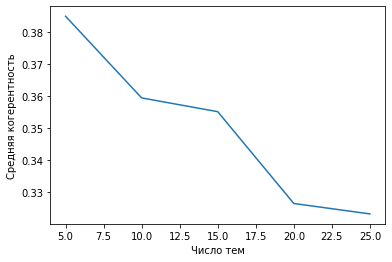

In [162]:
# подберем оптимальное количество тематик, опираясь на значение средней когерентности

topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda_temp = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda_temp, texts=preprocessed_text, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel('Число тем')
plt.ylabel('Средняя когерентность')
plt.show()

In [163]:
# обучим модель для 5 тематик
lda_5 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_5, corpus, dictionary)
pyLDAvis.display(vis_data)

In [164]:
# посмотрим на метрики

print('Персплексия: ', np.exp(lda_5.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda_5, texts=preprocessed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Персплексия:  0.0009868935500662597
Средняя когерентность:  0.38298536126576327


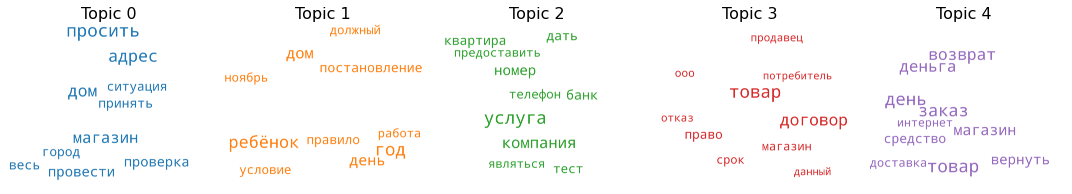

In [166]:
# изобразим тематики через облако токенов

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_list,
                  background_color='white',
                  width=3500,
                  height=2800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_5.show_topics(num_topics=5, formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### **ИНТЕРПРЕТАЦИЯ ТЕМАТИК**

* Topic_0: проверка магазинов на местах
* Topic_1: вопросы, связанные с детьми
* Topic_2: услуги компаний
* Topic_3: проблемы с товаром
* Topic_4: заказы в интернет-магазинах

### **ВЫВОД**

* Несмотря на то, что генерация весов происходит из распределения Дирихле, значения при разных запусках обучения получаются довольно различные.
* Чтобы выявить примерно какое количество тематик оптимальное, нужно посмотреть на несколько запусков обучения (в данном примере в большистве случаев выпадало 5  тематик и показывало наилучшую когерентность).
* Интерпритировать тематики по нескольким словам довольно не простая задача, многие слова пересекаются внутри разных тематик.
* Необходимо тщательно делать предобработку текстов, убирать мусорные слова, в том числе некоторые глаголы, прилагательные, союзы, которые не несут смысловой нагрузки.